In [1]:
import urllib
from IPython.display import display, clear_output
from PIL import Image
from collections import Counter

import matplotlib.pyplot as plt
# %matplotlib inline

import json


import os

import numpy as np

import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import h5py
import seaborn as sns
plt.ion()  
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    
from google.colab import drive
drive.mount('/content/gdrive')

torch.cuda.get_device_name(0)
print(torch.cuda.memory_allocated())

Using CUDA
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
0


In [0]:
# Utility functions

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

In [3]:
# Load the pretrained model from pytorch
vgg16 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 18.0MB/s]


In [4]:
print(vgg16)
# Freeze training for all layers
for param in vgg16.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
vgg16.fc = nn.Sequential(
               nn.Linear(2048, 1024),
               nn.ReLU(inplace=True),
               nn.Dropout(),
               nn.Linear(1024, 512),
               nn.ReLU(inplace=True),
               nn.Dropout(),
               nn.Linear(512, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(),
               nn.Linear(256, 4))
print(vgg16)

# # Freeze training for all layers
# for param in vgg16.parameters():
#     param.require_grad = False

# # Newly created modules have require_grad=True by default
# vgg16.fc = nn.Sequential(
#                 nn.Linear(2048, 1024),
#                nn.ReLU(inplace=True),
#                nn.Dropout(),
#                nn.Linear(1024, 512),
#                nn.ReLU(inplace=True),
#                nn.Dropout(),
#                nn.Linear(512, 256),
#                nn.ReLU(inplace=True),
#                nn.Dropout(),
#                nn.Linear(256, 128),
#                nn.ReLU(inplace=True),
#                nn.Dropout(),
#                nn.Linear(128, 6))
# print(vgg16)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
data_dir = './gdrive/My Drive/Colab/data5a'
TRAIN = 'training'
VAL = 'validation'
print(os.listdir(data_dir))

# VGG-16 Takes 224x224 images as input, so we resize all of them
  
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(30, translate=(0.2, 0.2), scale=(0.9, 1.2)),
        transforms.ColorJitter(brightness=.2,hue=.2, saturation=.2),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
#         transforms.Normalize([0.4362, 0.4276, 0.4359],
#                          	[0.2626, 0.2570, 0.2596])
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize([0.4362, 0.4276, 0.4359],
#                          	[0.2626, 0.2570, 0.2596])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=64,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}

for x in [TRAIN, VAL]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(class_names)

['validation', 'training']
Loaded 344 images under training
Loaded 84 images under validation
Classes: 
['door', 'hood', 'trunk', 'window']


In [0]:
# inputs, classes = next(iter(dataloaders[TRAIN]))
# show_databatch(inputs, classes)

In [0]:
# TODO: compose a test batch 

def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[VAL])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[VAL]):
        with torch.no_grad():
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

            vgg.train(False)
            vgg.eval()
            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_test += loss.item()
            acc_test += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
    
    print(acc_test)
    avg_loss = loss_test / dataset_sizes[VAL]
    avg_acc = acc_test.item() / dataset_sizes[VAL]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [0]:
def train_model(vgg, criterion, optimizer, num_epochs=10):
    torch.cuda.empty_cache()
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.cpu().state_dict())
    if use_gpu:
        vgg16.cuda()
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])

    lowered1 = False
    lowered2 = False
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 10 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
               
            optimizer.zero_grad() 
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()               
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
        print()

        avg_loss = loss_train / dataset_sizes[TRAIN]
        avg_acc = acc_train.item() / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            with torch.no_grad():
                if i % 10 == 0:
                    print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

                inputs, labels = data


                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss_val += loss.item()
                acc_val += torch.sum(preds == labels.data)
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val.item() / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.5f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print("memory usage: {:4f}".format(torch.cuda.memory_allocated()/1e8))
        print()
        # adjust lr:
        if avg_acc_val> 0.73 and not lowered1:
          print("Lowering LR1")
          lowered1 = True
          for g in optimizer.param_groups:
              g['lr'] = 0.001

        if avg_acc_val> 0.78 and not lowered2:
          lowered2 = True
          print("Lowering LR2")
          for g in optimizer.param_groups:
              g['lr'] = 0.0002
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.cpu().state_dict())
            if use_gpu:
                vgg16.cuda()
        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [9]:
if use_gpu:
    vgg16.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)#optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)#optim.SGD(train_layer.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005) #optim.Adam(train_layer.parameters(), lr=0.001)
# eval_model(vgg16, criterion)
print(torch.cuda.memory_allocated()/1e9)

0.10582528


In [0]:
# vgg16 = train_model(vgg16, criterion, optimizer, num_epochs=150)

In [11]:
# batch size 4, 0 worker: 3m45s
# batch size 4, 1 worker: 3m38s
# batch size 8, 1 worker: 3m7s
# batch size 8, 1 worker (optim only taking 1 row): 2m 47s (val acc 0.6023)
# batch size 8, 1 worker (optim only taking 1 row, decharging memory less often): 2m39s (val acc 0.6023)
# batch size 12, 2 worker (optim only taking 1 row, decharging memory less often): 2m43s (val acc 0.6023)
# batch size 12, 2 worker (decharging memory less often): 2m43s (val acc 0.6023)
# batch size 12, 2 worker (optim only taking 1 row, decharging memory less often, optim less often): 2m43s (val acc 0.6023)
    
# batch size 16, 1 worker, resize to 112x112, size 16: 0.58s
# optim.SGD(train_layer.parameters(), lr=0.001, momentum=0.9), 0.66 max val acc (epoch 2)
# optim.Adam(train_layer.parameters(), lr=0.001), 0.66 max val acc (epoch 17)
# optim.Adam(train_layer.parameters(), lr=0.001), with training every 3, 0.66 max val acc (epoch 20)

# SGD, lr=0.001, momentum=0.9, weight_decay=0.0001, train_every=5: val:0.65 (ep 11)
# SGD, lr=0.00001, momentum=0.9, weight_decay=0.00001, train_every=5: SLOW,
# SGD, lr=0.0001, momentum=0.9, weight_decay=0.00001, train_every=5: 0.64 (ep 21)
# SGD, lr=0.0001, momentum=0.9, train_every=5: 

# late crop: 0.79
# early crop: 

# torch.save(vgg16.state_dict(), 'res_part_83')
vgg16.load_state_dict(torch.load("./gdrive/My Drive/Colab/res_part_83"))

<All keys matched successfully>

In [16]:
eval_model(vgg16, criterion)

Evaluating model
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Test batch 1/2tensor(69, device='cuda:0')

Evaluation completed in 0m 2s
Avg loss (test): 0.0156
Avg acc (test): 0.8214
----------


In [0]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0
    with torch.no_grad():
        for i, data in enumerate(dataloaders[VAL]):
            inputs, labels = data
            size = inputs.size()[0]

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]

            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)

            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()

            images_so_far += size
            if images_so_far >= num_images:
                break
        
    vgg.train(mode=was_training) # Revert model back to original training state

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Ground truth:


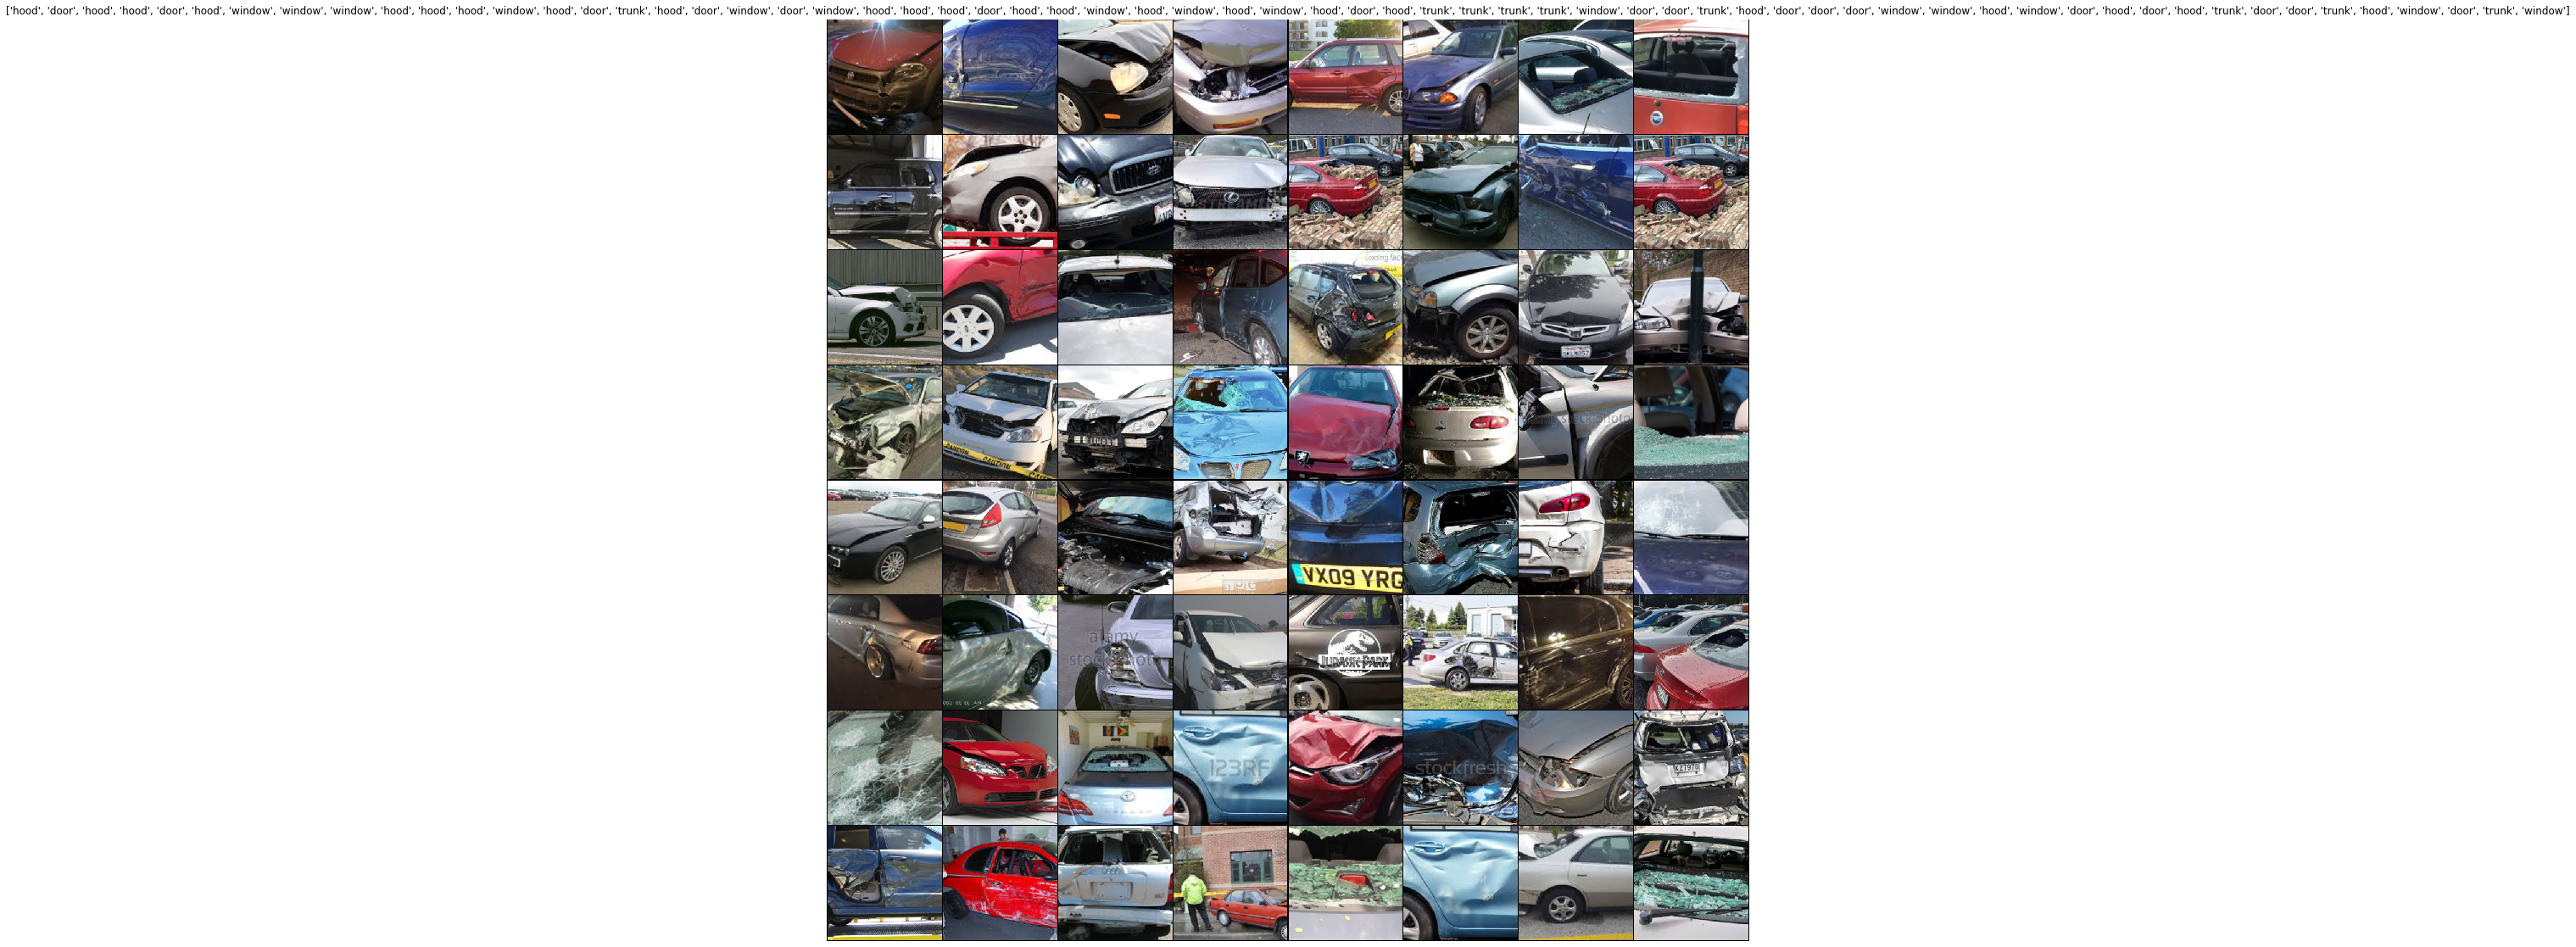

Prediction:


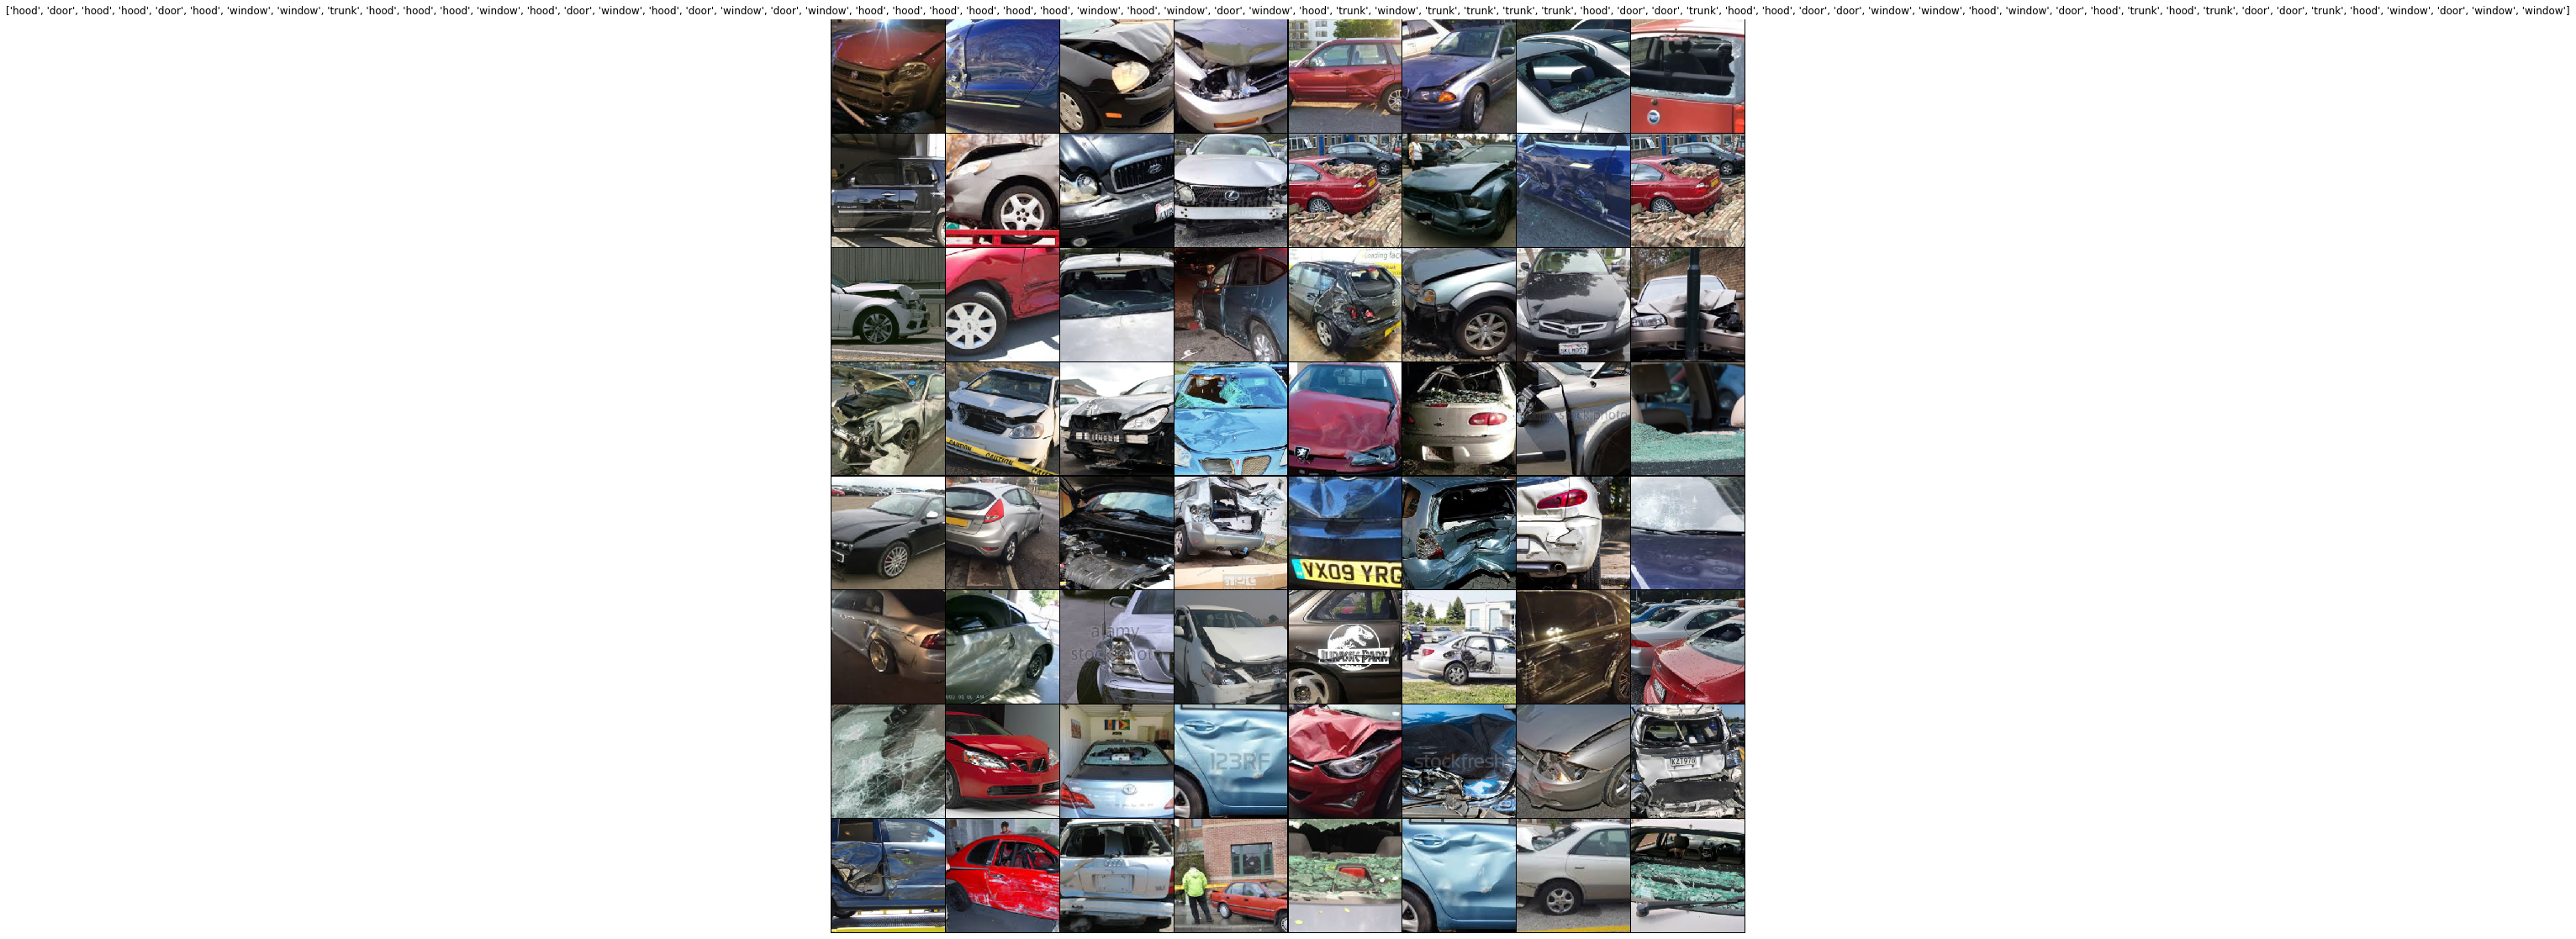

In [18]:
visualize_model(vgg16)